## Section 0. Ensure Dependencies

In [83]:
install.packages('reshape2', dependencies = TRUE, repos = 'http://cran.us.r-project.org')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


In [84]:
library(tidytext)
library(magrittr)
library(dplyr)
library(stringr)
library(textclean)
library(ggplot2)
library(reshape2)

## Section 1. Data Preparation

### Step 1: Read Data

In [14]:
spooky <- read.csv('../data/spooky.csv', as.is = TRUE)
spooky$author <- spooky$author %>% as.factor()
spooky$text <- spooky$text %>% replace_contraction()

### Step 2: Process Data - Split sentences into words

We use `unnest_tokens()` to process the data into tidy format for ease of analysis. For the subsequent analyses, we need:
- One dataframe that drops punctuations, turns words into lower case, but does not remove stop words
- One dataframe that drops punctuations, removes everything with higher case, removes all stop words, then turned to lower case

In [19]:
sws <- spooky_with_stopwords <- spooky %>% 
    unnest_tokens(word, text)
soc <- spooky_original_case <- spooky %>% 
    unnest_tokens(word, text, to_lower = FALSE) %>%
    drop_row('word', c('[A-Z]')) %>% 
    anti_join(stop_words, by = "word")

## Section 2. "Gothic" Keywords Comparison

In this section, we will compare the relative frequency of British Gothic keywords identified by [Jones (2010)](https://www.era.lib.ed.ac.uk/bitstream/handle/1842/5351/Dissertation_Final.pdf;sequence=1), which include 
- Pronouns (especially first-person and second-person)
    - Examples: I, me, myself, you, yourself, etc.
- Vocatives (names, titles, etc.)
    - Examples: Adrian, Miss, Mr, etc.
- Body parts 
    - Examples: Arms, foreheads, lips, etc.
- "Gothic" words (words related to a dark and supernatural atmosphere)
    - Examples: Fear, curiosity, silence, dark, dead, spirit

Because the identification of vocatives, especially names, deserves attention as a project on its own, I decide to examine the other three categories of keywords. Jones (2010) identified Gothic keywords as those that appear more frequently in Gothic writing than in a general English corpus. In this project, we choose compare the distribution of these keywords in our dataset against the "Gothic" pattern he discovered. 

Because in our dataset, the three authors have different numbers of sentences, we scale the word frequency of each author by the total number of words by each author. 
$$
    \text{rel_freq}(\text{word}, \text{author}) 
    = \frac{\text{# occurrence of word}}{\text{total # words by author}}
$$


In [27]:
# For pronouns
# Word count by author
author_count = sws %>%
    group_by(author) %>%
    count()
# Count of every word for each author
author_word_count = sws %>%
    group_by(author, word) %>%
    count()

In [54]:
author_rel_freq <- author_word_count %>% 
    select(author, word, count = n) %>%
    left_join(author_words %>% 
                 select(author, total_count = n),
              by = 'author') %>% 
    mutate(rel_freq = count / total_count) %>%
    select(.data$author, .data$word, .data$rel_freq)
author_rel_freq <- author_rel_freq[order(-author_rel_freq$rel_freq),]

In [76]:
# Obtain rankings
author_rel_freq$rank <- NA
EAP_words = author_rel_freq[author_rel_freq$author == 'EAP',] 
HPL_words = author_rel_freq[author_rel_freq$author == 'HPL',]
MWS_words = author_rel_freq[author_rel_freq$author == 'MWS',]

author_rel_freq[author_rel_freq$author == 'EAP','rank'] <- 1:nrow(EAP_words)
author_rel_freq[author_rel_freq$author == 'HPL','rank'] <- 1:nrow(HPL_words)
author_rel_freq[author_rel_freq$author == 'MWS','rank'] <- 1:nrow(MWS_words)

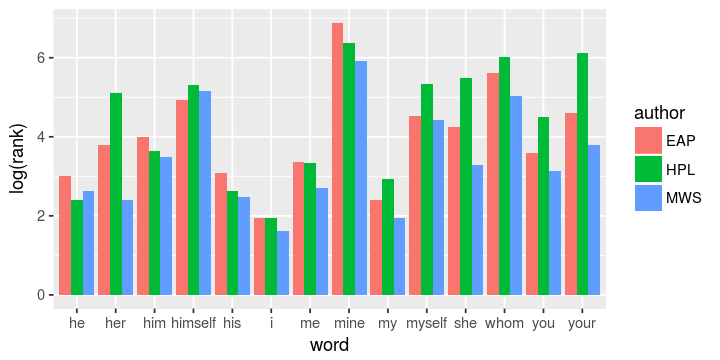

In [93]:
pronouns <- c('i', 'my', 'me', 'myself', 'you', 'your', 'he', 'his', 'him', 'himself', 
              'she', 'her', 'mine', 'whom')
author_pronoun_rel_freq <- author_rel_freq[author_rel_freq$word %in% pronouns,]

options(repr.plot.width = 6, repr.plot.height = 3)
ggplot(author_pronoun_rel_freq, aes(x=word, y=log(rank), fill = author)) + 
    geom_bar(position="dodge", stat="identity") 

## Section 3. Gothic keywords comparison

## Section 4. Statistical Test

## Section 5. k-means on sentence sentiments